# Evaluate the classification models on the validation data

# Import Libaries

In [1]:
import numpy as np
import pandas as pd

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    f1_score,
    confusion_matrix,
    classification_report
)


# Load data

In [2]:
df = pd.read_json("data/val/embeddings/val_embeddings.json")
df.head()

,case_id,clean_content,chunks,num_chunks,issue_category,mean_embedding
0,3,"The case ""David B. v. McDonald"" from Illinois ...","['The case ""David B. v. McDonald"" from Illinoi...",10,"[Disability and Disability Rights, General/Mis...","[-0.6259282231000001, -0.40986889600000004, -0..."
1,16,"The case ""Harrelson v. Elmore County"" from Ala...","['The case ""Harrelson v. Elmore County"" from A...",1,"[Discrimination Basis, General/Misc.]","[-0.4564437568, -0.0400216319, 0.0276959930000..."
2,24,"The case ""Hill v. Pulaski County"" from Arkansa...","['The case ""Hill v. Pulaski County"" from Arkan...",1,"[General/Misc., Jails, Prisons, Detention Cent...","[-0.3162397146, -0.1830663979, -0.152661413, 0..."
3,29,"The case ""U.S. v. Maricopa County"" from Arizon...","['The case ""U.S. v. Maricopa County"" from Ariz...",1,"[Jails, Prisons, Detention Centers, and Other ...","[-0.37856322530000003, -0.0893824548, -0.17855..."
4,146,"The case ""Tyler v. Percich"" from Missouri was ...","['The case ""Tyler v. Percich"" from Missouri wa...",2,"[General/Misc., Jails, Prisons, Detention Cent...","[-0.7671036720000001, -0.418065846, 0.01603331..."


# Assign Labels

For this round of experiments, I only (randomly) picked 5 issue categories.

In [3]:
len(df)

800

In [4]:
abbreviations = {
    'COVID-19': 'COVID',
    'Benefits (Source)': 'BENEFITS',
    'Affected Race(s)': 'RACE',
    'EEOC-centric': 'EEOC',
    'Affected Sex/Gender(s)': 'GENDER',
}

In [5]:
cat_keys = list(abbreviations.keys())
cat_values = list(abbreviations.values())

df['issue_category'] = df['issue_category'].apply(lambda labels: [label for label in labels if label in cat_keys])

In [6]:
df["issue_category"].value_counts()

issue_category
[]                                                          441
[Affected Sex/Gender(s)]                                    103
[Affected Sex/Gender(s), EEOC-centric]                       89
[Affected Race(s)]                                           61
[EEOC-centric]                                               32
[Affected Race(s), EEOC-centric]                             19
[Affected Race(s), Affected Sex/Gender(s)]                   17
[Benefits (Source)]                                          15
[Affected Race(s), Affected Sex/Gender(s), EEOC-centric]      8
[COVID-19]                                                    8
[Affected Sex/Gender(s), Benefits (Source)]                   3
[Affected Sex/Gender(s), COVID-19]                            2
[Affected Race(s), Benefits (Source)]                         1
[Benefits (Source), COVID-19]                                 1
Name: count, dtype: int64

In [7]:
for key, cat in abbreviations.items():
    df[f'is_{cat}'] = df['issue_category'].apply(lambda x: int(key in x))

In [8]:
df.head()

,case_id,clean_content,chunks,num_chunks,issue_category,mean_embedding,is_COVID,is_BENEFITS,is_RACE,is_EEOC,is_GENDER
0,3,"The case ""David B. v. McDonald"" from Illinois ...","['The case ""David B. v. McDonald"" from Illinoi...",10,[],"[-0.6259282231000001, -0.40986889600000004, -0...",0,0,0,0,0
1,16,"The case ""Harrelson v. Elmore County"" from Ala...","['The case ""Harrelson v. Elmore County"" from A...",1,[],"[-0.4564437568, -0.0400216319, 0.0276959930000...",0,0,0,0,0
2,24,"The case ""Hill v. Pulaski County"" from Arkansa...","['The case ""Hill v. Pulaski County"" from Arkan...",1,[],"[-0.3162397146, -0.1830663979, -0.152661413, 0...",0,0,0,0,0
3,29,"The case ""U.S. v. Maricopa County"" from Arizon...","['The case ""U.S. v. Maricopa County"" from Ariz...",1,[],"[-0.37856322530000003, -0.0893824548, -0.17855...",0,0,0,0,0
4,146,"The case ""Tyler v. Percich"" from Missouri was ...","['The case ""Tyler v. Percich"" from Missouri wa...",2,[],"[-0.7671036720000001, -0.418065846, 0.01603331...",0,0,0,0,0


# Load the models & set the classification threshold

The models are selected based on the validation performance observed at training. To the extent multiple models had the exact same performance, we prefer SVM and XGBoost over Logistic Regression. Random Forest (as expected) cannot compete with other algorithms so Random Forest models are not considered.

The classification thresholds are experimented and assigned based on class to achieve the best performance for each class.

In [10]:
models = {"COVID": joblib.load('models/COVID_LR.pkl'),
          "BENEFITS": joblib.load('models/BENEFITS_SVM.pkl'),
          "RACE": joblib.load('models/RACE_SVM.pkl'),
          "GENDER": joblib.load('models/GENDER_LR.pkl'),
          "EEOC": joblib.load('models/EEOC_SVM.pkl'),
}

thresholds = {"COVID": 0.95,
              "BENEFITS":0.9,
              "RACE": 0.7,
              "GENDER": 0.75,
              "EEOC": 0.65,
}

# Run evaluation

In [11]:
X = np.stack(df['mean_embedding'].values)

In [12]:
# Dictionary to store predictions and true labels
predictions = {}
true_labels = {}

for cat in cat_values:
    model = models[cat]  # or use a dict instead
    y_true = df[f'is_{cat}'].values
    y_pred_proba = model.predict_proba(X)[:, 1]  # probability of positive class

    predictions[cat] = y_pred_proba
    true_labels[cat] = y_true

    proba_col = f'pred_prob_{cat}'
    label_col = f'pred_label_{cat}'

    df[proba_col] = y_pred_proba
    df[label_col] = (df[proba_col] >= thresholds[cat]).astype(int)

In [13]:
df.head()

,case_id,clean_content,chunks,num_chunks,issue_category,mean_embedding,is_COVID,is_BENEFITS,is_RACE,is_EEOC,...,pred_prob_COVID,pred_label_COVID,pred_prob_BENEFITS,pred_label_BENEFITS,pred_prob_RACE,pred_label_RACE,pred_prob_EEOC,pred_label_EEOC,pred_prob_GENDER,pred_label_GENDER
0,3,"The case ""David B. v. McDonald"" from Illinois ...","['The case ""David B. v. McDonald"" from Illinoi...",10,[],"[-0.6259282231000001, -0.40986889600000004, -0...",0,0,0,0,...,0.042879,0,0.620044,0,0.116391,0,0.008598,0,0.526264,0
1,16,"The case ""Harrelson v. Elmore County"" from Ala...","['The case ""Harrelson v. Elmore County"" from A...",1,[],"[-0.4564437568, -0.0400216319, 0.0276959930000...",0,0,0,0,...,0.003501,0,0.546433,0,0.150482,0,0.223956,0,0.895997,1
2,24,"The case ""Hill v. Pulaski County"" from Arkansa...","['The case ""Hill v. Pulaski County"" from Arkan...",1,[],"[-0.3162397146, -0.1830663979, -0.152661413, 0...",0,0,0,0,...,0.057990,0,0.059390,0,0.379288,0,0.003242,0,0.673975,0
3,29,"The case ""U.S. v. Maricopa County"" from Arizon...","['The case ""U.S. v. Maricopa County"" from Ariz...",1,[],"[-0.37856322530000003, -0.0893824548, -0.17855...",0,0,0,0,...,0.030786,0,0.086701,0,0.312978,0,0.021740,0,0.080263,0
4,146,"The case ""Tyler v. Percich"" from Missouri was ...","['The case ""Tyler v. Percich"" from Missouri wa...",2,[],"[-0.7671036720000001, -0.418065846, 0.01603331...",0,0,0,0,...,0.048691,0,0.013672,0,0.045207,0,0.005304,0,0.382435,0


In [14]:
def evaluate_model(category, y_true, y_pred_proba, threshold):

    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    auprc = average_precision_score(y_true, y_pred_proba)

    # Compute baseline = proportion of positive class
    baseline = sum(y_true) / len(y_true)

    plt.figure(figsize=(16, 5))
    
    # Precision-Recall Curve Plot
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}', color='darkorange')
    plt.hlines(baseline, xmin=0, xmax=1, colors='gray', linestyles='dashed', label=f'Baseline = {baseline:.2f}')
    plt.title(f'Precision-Recall Curve - {category}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(False)  # ← remove gridlines

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix - {category}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\nClassification Report - {category}")
    print(classification_report(y_true, y_pred))


===== Evaluating COVID =====


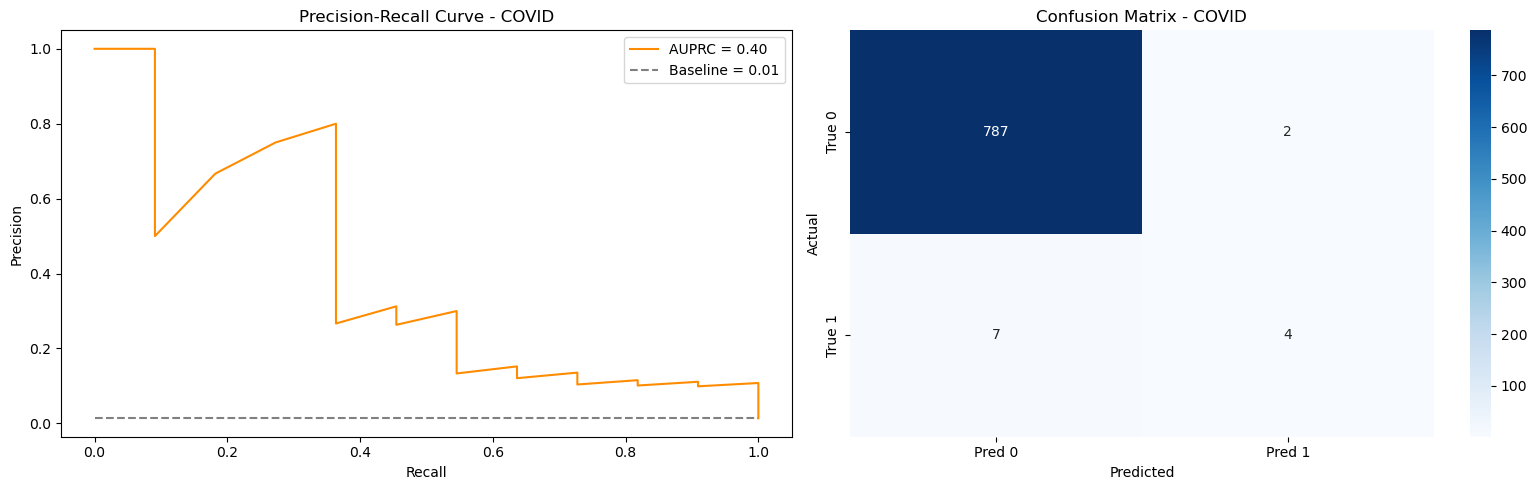


Classification Report - COVID
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       789
           1       0.67      0.36      0.47        11

    accuracy                           0.99       800
   macro avg       0.83      0.68      0.73       800
weighted avg       0.99      0.99      0.99       800


===== Evaluating BENEFITS =====


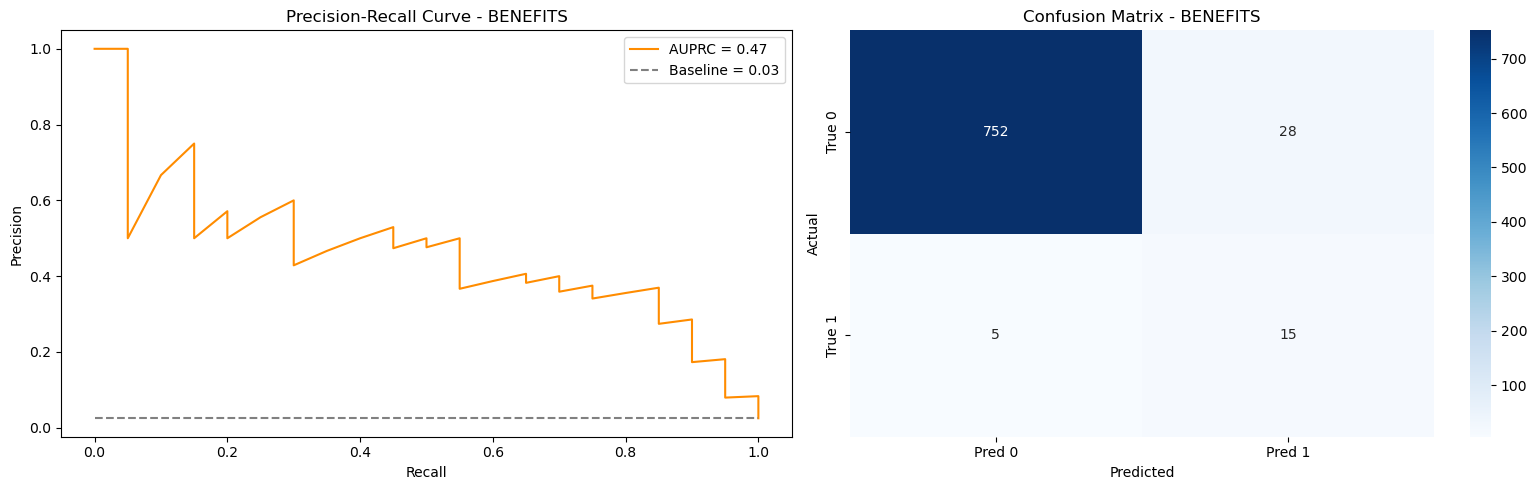


Classification Report - BENEFITS
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       780
           1       0.35      0.75      0.48        20

    accuracy                           0.96       800
   macro avg       0.67      0.86      0.73       800
weighted avg       0.98      0.96      0.97       800


===== Evaluating RACE =====


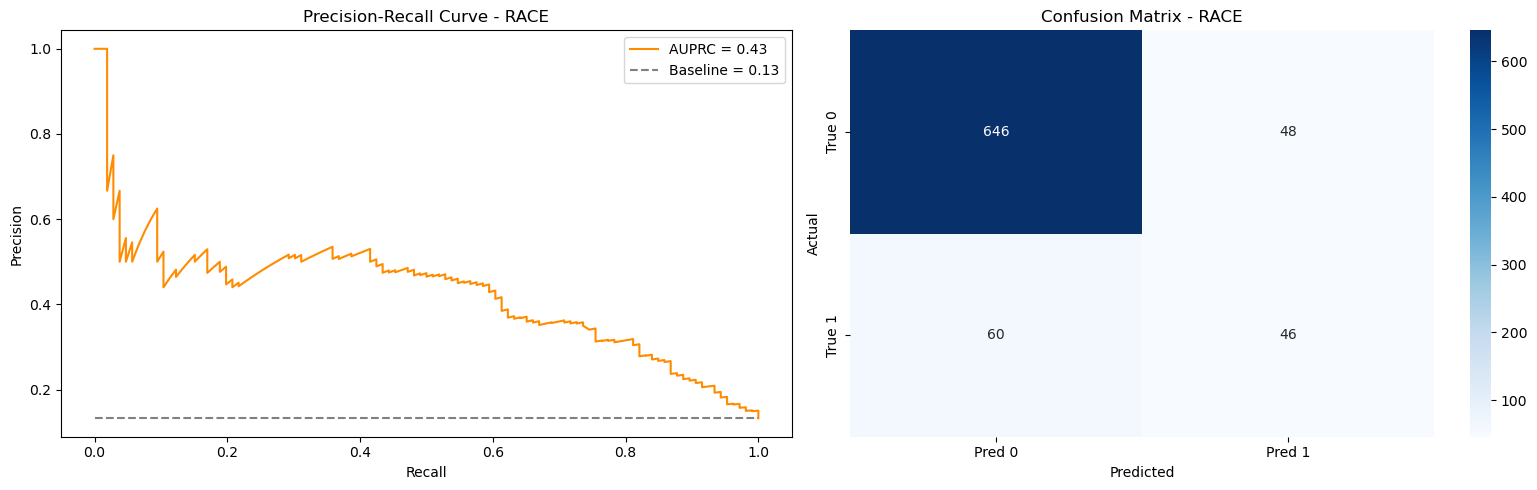


Classification Report - RACE
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       694
           1       0.49      0.43      0.46       106

    accuracy                           0.86       800
   macro avg       0.70      0.68      0.69       800
weighted avg       0.86      0.86      0.86       800


===== Evaluating EEOC =====


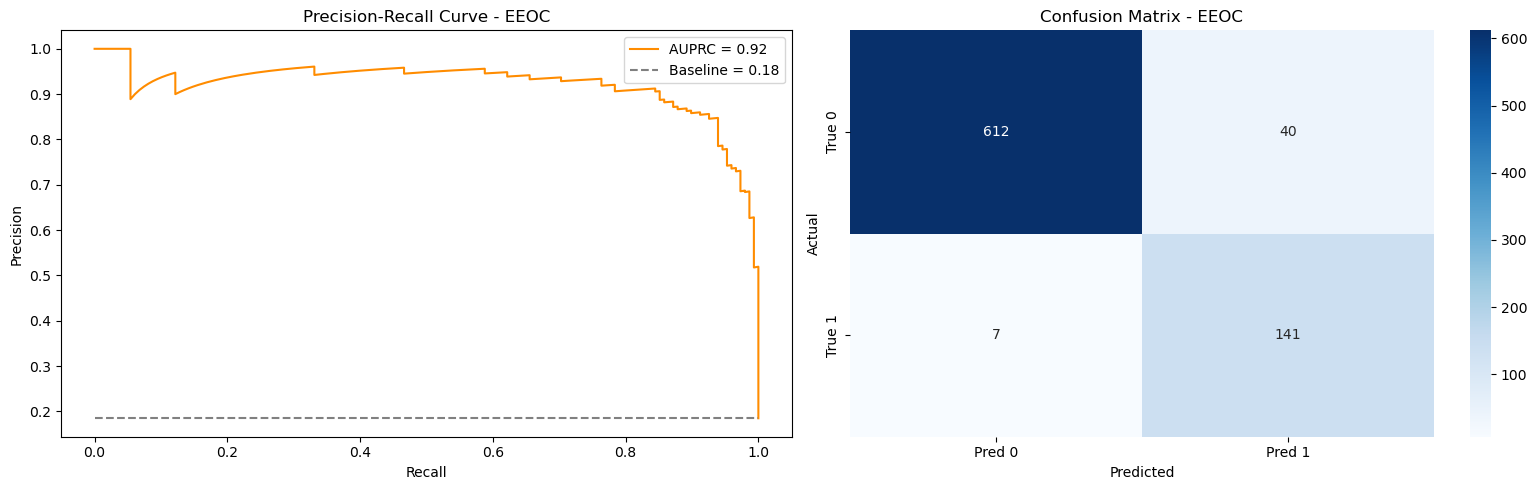


Classification Report - EEOC
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       652
           1       0.78      0.95      0.86       148

    accuracy                           0.94       800
   macro avg       0.88      0.95      0.91       800
weighted avg       0.95      0.94      0.94       800


===== Evaluating GENDER =====


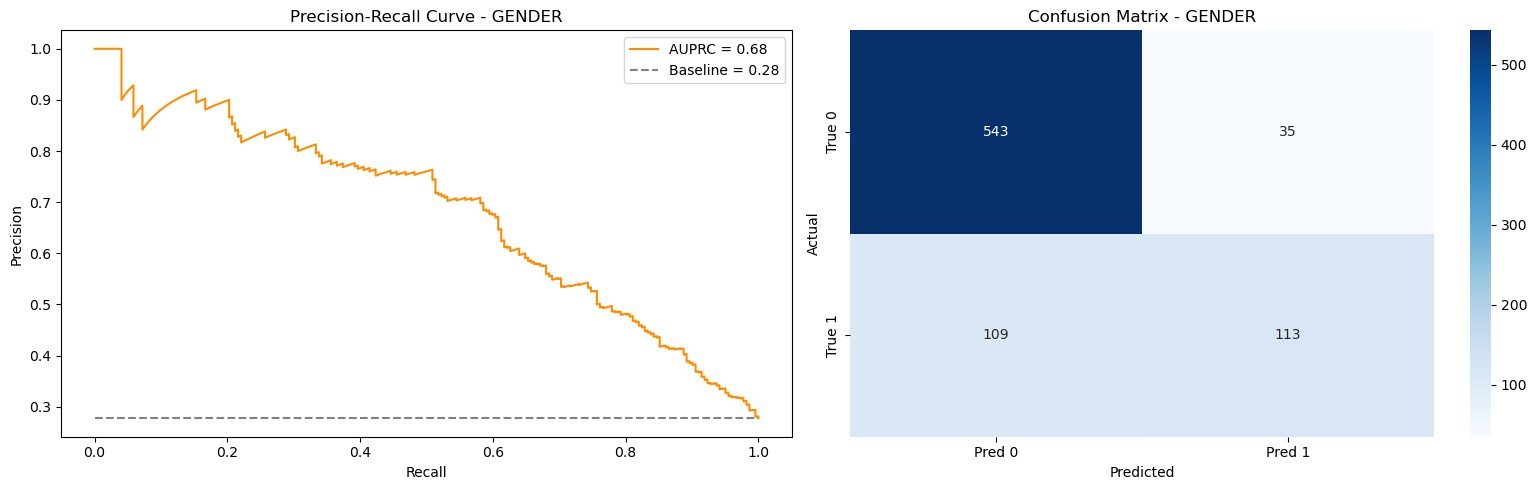


Classification Report - GENDER
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       578
           1       0.76      0.51      0.61       222

    accuracy                           0.82       800
   macro avg       0.80      0.72      0.75       800
weighted avg       0.81      0.82      0.81       800



In [15]:
for cat in cat_values:
    print(f"\n===== Evaluating {cat} =====")
    y_true = df[f'is_{cat}'].values
    y_pred_proba = predictions[cat]
    evaluate_model(cat, y_true, y_pred_proba, thresholds[cat])